# **Importing the Libraries**

In [1]:
import os
import torch
import librosa
import torchaudio
import numpy as np
import pandas as pd
import torch.nn as nn
import soundfile as sf
#import sounddevice as sd
import torch.optim as optim
import IPython.display as ipd
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
#from transformers import Speech2TextProcessor, Speech2TextForSequenceClassification
from transformers import AutoConfig, Wav2Vec2Processor, Wav2Vec2Model, Wav2Vec2ForCTC, Wav2Vec2FeatureExtractor

In [2]:
dataset_dir = '/kaggle/input/telugu-hate-speech'
hate_dir = os.path.join(dataset_dir, 'Hate')
non_hate_dir = os.path.join(dataset_dir, 'Non Hate')

# **Extracting the Meta Data from Audio Files**

In [3]:
# Initialize an empty list to store the file information
data = []

# Iterate through the "Hate" and "Non Hate" folders
for label in ["Hate", "Non Hate"]:
    folder_path = os.path.join(dataset_dir, label)
    
    # For "Hate" category, also iterate through the subfolders
    if label == "Hate":
        for sub_category in ["Character Assassination", "Gender", "Political", "Religion"]:
            sub_folder_path = os.path.join(folder_path, sub_category)
            for file_name in os.listdir(sub_folder_path):
                # Parse details from the file name
                parts = file_name.split('_')
                hate_or_non_hate = "Hate"
                sub_category_code = parts[3]  # e.g., C, G, P, or R
                gender = parts[4]
                
                # Store details in a dictionary
                file_info = {
                    "File Name": file_name,
                    "Hate or Non Hate": hate_or_non_hate,
                    "Sub Category": sub_category_code,
                    "Gender": gender,
                    "File Path": os.path.join(sub_folder_path, file_name)
                }
                data.append(file_info)
    else:
        # For "Non Hate" files, only iterate through the files directly
        for file_name in os.listdir(folder_path):
            parts = file_name.split('_')
            hate_or_non_hate = "Non Hate"
            sub_category_code = "NH"  # No sub-category for non-hate files
            gender = parts[4]
            
            # Store details in a dictionary
            file_info = {
                "File Name": file_name,
                "Hate or Non Hate": hate_or_non_hate,
                "Sub Category": sub_category_code,
                "Gender": gender,
                "File Path": os.path.join(folder_path, file_name)
            }
            data.append(file_info)

# Create a DataFrame from the collected data
df = pd.DataFrame(data)

In [4]:
df

,File Name,Hate or Non Hate,Sub Category,Gender,File Path
0,H_TE_003_C_M_035_004.mp3,Hate,C,M,/kaggle/input/telugu-hate-speech/Hate/Characte...
1,H_TE_003_C_F_024_003.mp3,Hate,C,F,/kaggle/input/telugu-hate-speech/Hate/Characte...
2,H_TE_003_C_M_020_009.mp3,Hate,C,M,/kaggle/input/telugu-hate-speech/Hate/Characte...
3,H_TE_003_C_M_035_003.mp3,Hate,C,M,/kaggle/input/telugu-hate-speech/Hate/Characte...
4,H_TE_003_C_M_016_001.mp3,Hate,C,M,/kaggle/input/telugu-hate-speech/Hate/Characte...
...,...,...,...,...,...
596,NH_TE_001_N_M_005_001.mp3,Non Hate,NH,M,/kaggle/input/telugu-hate-speech/Non Hate/NH_T...
597,NH_TE_002_N_F_003_001.mp3,Non Hate,NH,F,/kaggle/input/telugu-hate-speech/Non Hate/NH_T...
598,NH_TE_003_N_F_008_002.mp3,Non Hate,NH,F,/kaggle/input/telugu-hate-speech/Non Hate/NH_T...
599,NH_TE_002_N_M_012_001.mp3,Non Hate,NH,M,/kaggle/input/telugu-hate-speech/Non Hate/NH_T...


# **Distribution of Hate & Non Hate Samples**

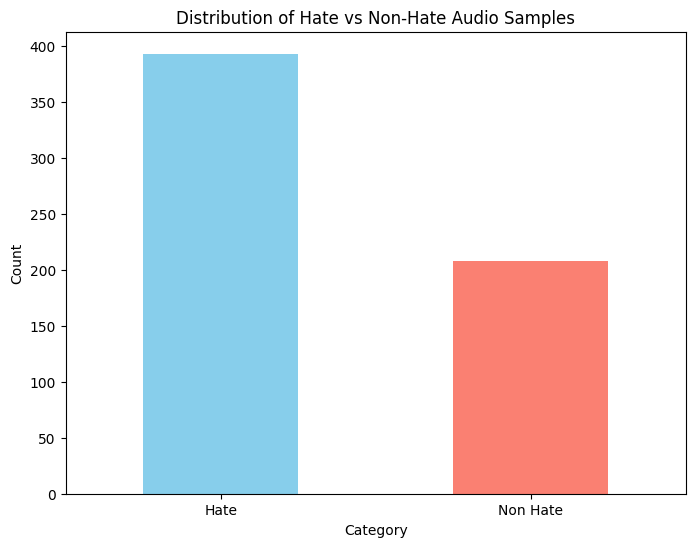

In [5]:
# Get the count of each category (Hate vs Non Hate)
hate_non_hate_counts = df["Hate or Non Hate"].value_counts()

# Plot the distribution as a bar graph
plt.figure(figsize=(8, 6))
hate_non_hate_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Hate vs Non-Hate Audio Samples')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# **Distribution of Samples per Category**

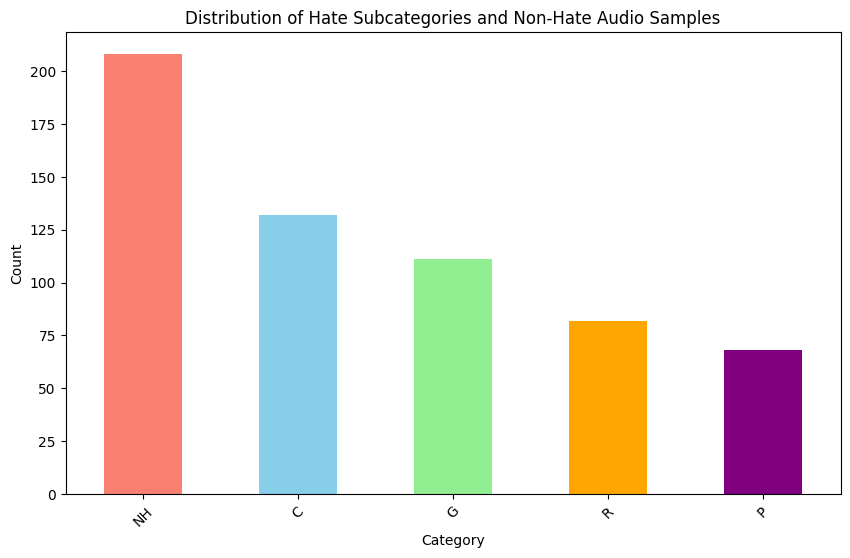

In [6]:
# Replace NaN in "Sub Category" with "Non Hate" for easier grouping
df['Sub Category'] = df['Sub Category'].fillna('Non Hate')

# Get the count of each subcategory (including Non Hate)
subcategory_counts = df['Sub Category'].value_counts()

# Plot the distribution as a bar graph
plt.figure(figsize=(10, 6))
subcategory_counts.plot(kind='bar', color=['salmon', 'skyblue', 'lightgreen', 'orange', 'purple'])
plt.title('Distribution of Hate Subcategories and Non-Hate Audio Samples')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# **Gender Samples Distribution**

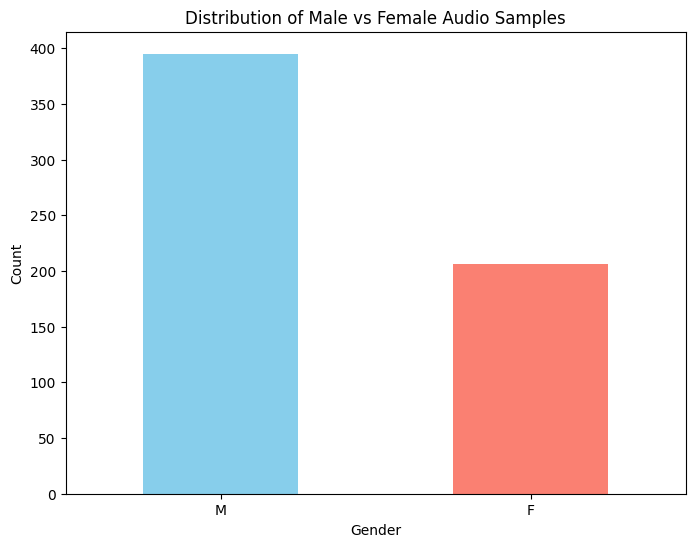

In [7]:
# Get the count of each category (Hate vs Non Hate)
hate_non_hate_counts = df["Gender"].value_counts()

# Plot the distribution as a bar graph
plt.figure(figsize=(8, 6))
hate_non_hate_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Male vs Female Audio Samples')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# **Duration of Audio Files per Category**

In [8]:
def get_audio_duration(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return librosa.get_duration(y=audio, sr=sr)

df['Duration'] = df['File Path'].apply(get_audio_duration)

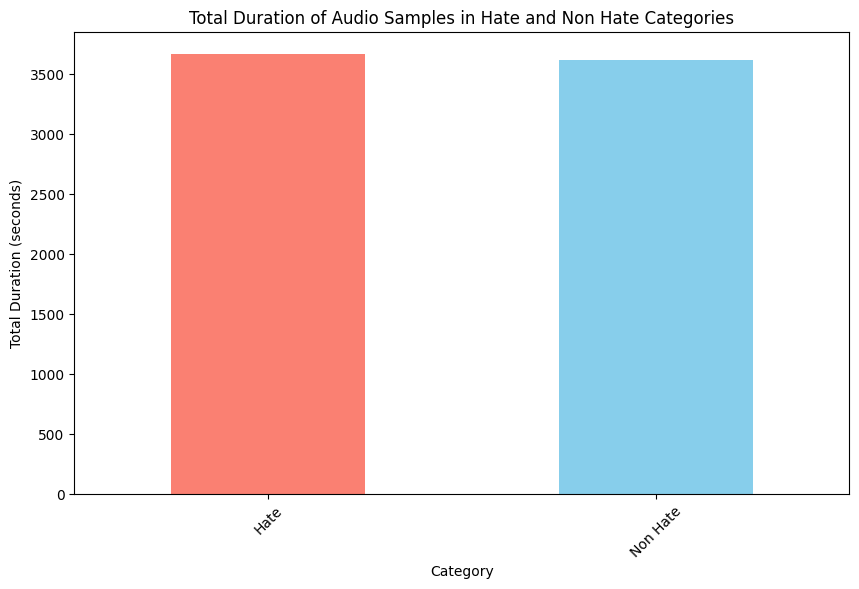

In [9]:
total_durations_HateorNonHate = df.groupby('Hate or Non Hate')['Duration'].sum()
                                                                                
# Plot the total duration for each category
plt.figure(figsize=(10, 6))
total_durations_HateorNonHate.plot(kind='bar', color=['salmon', 'skyblue'])
plt.title('Total Duration of Audio Samples in Hate and Non Hate Categories')
plt.xlabel('Category')
plt.ylabel('Total Duration (seconds)')
plt.xticks(rotation=45)
plt.show()

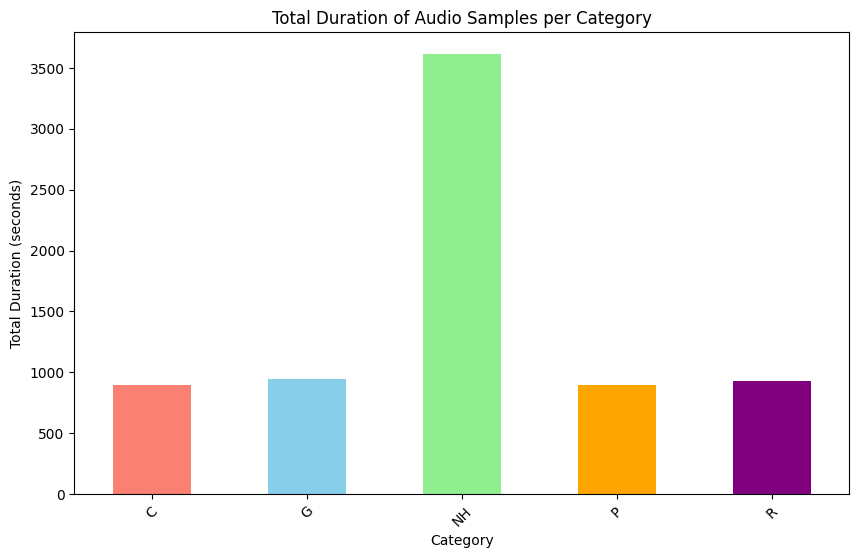

In [10]:
total_durations_per_category = df.groupby('Sub Category')['Duration'].sum()
                                                                                
# Plot the total duration for each category
plt.figure(figsize=(10, 6))
total_durations_per_category.plot(kind='bar', color=['salmon', 'skyblue', 'lightgreen', 'orange', 'purple'])
plt.title('Total Duration of Audio Samples per Category')
plt.xlabel('Category')
plt.ylabel('Total Duration (seconds)')
plt.xticks(rotation=45)
plt.show()

In [11]:
total_durations_per_category

Sub Category
C      894.518980
G      945.162290
NH    3612.558844
P      894.390023
R      929.868413
Name: Duration, dtype: float64

# **Outliers detection based on Duration**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


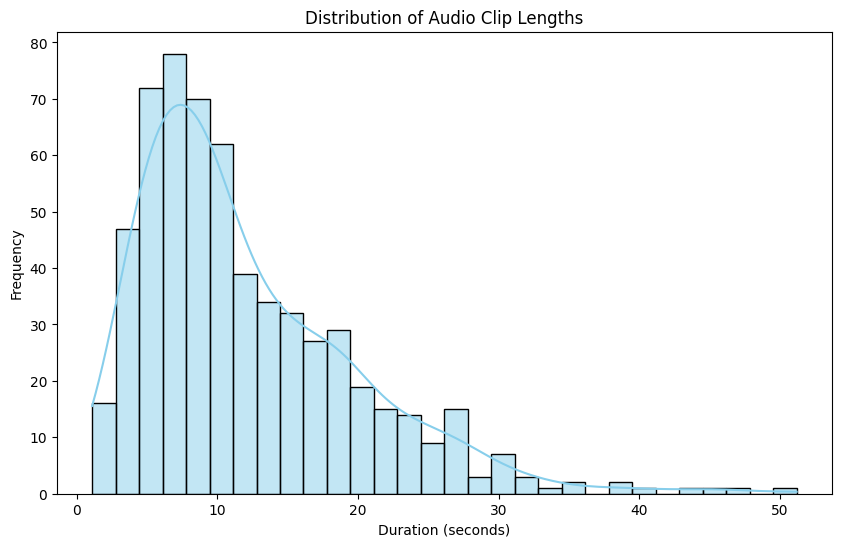

Outliers in Duration (in seconds):
                      File Name   Duration Sub Category
395   NH_TE_002_N_F_005_005.mp3  43.112494           NH
397  NH_TE_002_N_M_0011_001.mp3  46.789819           NH
407   NH_TE_002_N_F_009_001.mp3  33.802154           NH
437   NH_TE_002_N_M_007_001.mp3  34.827007           NH
452   NH_TE_003_N_M_004_002.mp3  30.014694           NH
454   NH_TE_002_N_F_008_001.mp3  40.829501           NH
461   NH_TE_002_N_F_006_001.mp3  32.523356           NH
470   NH_TE_001_N_M_039_001.mp3  29.650000           NH
477  NH_TE_002_N_F_0010_003.mp3  30.184127           NH
483   NH_TE_002_N_F_005_004.mp3  35.777392           NH
485   NH_TE_002_N_F_005_003.mp3  32.633764           NH
486   NH_TE_001_N_M_020_001.mp3  38.220000           NH
490   NH_TE_002_N_F_004_002.mp3  30.473311           NH
494   NH_TE_001_N_M_040_006.mp3  29.000000           NH
497  NH_TE_002_N_M_0011_002.mp3  28.302132           NH
498  NH_TE_002_N_M_0011_003.mp3  30.812812           NH
529   NH_TE_0

In [12]:
import seaborn as sns

# Plot the overall distribution of clip lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['Duration'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Audio Clip Lengths')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

# Calculate basic statistics for duration
mean_duration = df['Duration'].mean()
std_duration = df['Duration'].std()

# Define outlier thresholds (e.g., mean ± 2*std)
lower_threshold = mean_duration - 2 * std_duration
upper_threshold = mean_duration + 2 * std_duration

# Identify outliers
outliers = df[(df['Duration'] < lower_threshold) | (df['Duration'] > upper_threshold)]
print("Outliers in Duration (in seconds):")
print(outliers[['File Name', 'Duration', 'Sub Category']])

# Suggested duration range based on the data (e.g., 5th to 95th percentile)
suggested_min, suggested_max = np.percentile(df['Duration'], [5, 95])
print(f"Suggested duration range for padding/truncation: {suggested_min:.2f} - {suggested_max:.2f} seconds")

# **Checking for Sampling Rate**

In [13]:
def check_sampling_rate(file):
    y, sr = librosa.load(file, sr=None)
    return sr

df['sampling_rate'] = df['File Path'].apply(check_sampling_rate)
print(df['sampling_rate'].value_counts())

sampling_rate
44100    600
48000      1
Name: count, dtype: int64


# **Resampling the audio files to 16000Hz**

In [14]:
def copy_and_resample_audio(df, input_dir, output_dir, target_sr=16000):
    
    os.makedirs(output_dir, exist_ok=True)
    resampled_rates = []
    new_file_paths = []

    for index, row in df.iterrows():
        # Get the original file path
        original_file_path = row['File Path']
        
        # Determine the relative path to maintain the structure
        relative_path = os.path.relpath(original_file_path, input_dir)
        new_file_path = os.path.join(output_dir, relative_path)

        # Create necessary directories for the new file path
        os.makedirs(os.path.dirname(new_file_path), exist_ok=True)

        # Load the original audio file
        original_audio, sr_original = librosa.load(original_file_path, sr=None)

        # Resample the audio
        resampled_audio = librosa.resample(original_audio, orig_sr=sr_original, target_sr=target_sr)

        # Save the resampled audio to the new file path as .mp3
        sf.write(new_file_path, resampled_audio, target_sr, format='MP3')

        # Append the new sampling rate and new file path to their respective lists
        resampled_rates.append(target_sr)
        new_file_paths.append(new_file_path)  # Keep it in .mp3 format

    # Add the new columns to the DataFrame
    df['Resampled Sampling Rate'] = resampled_rates
    df['New File Path'] = new_file_paths
    
    return df

input_directory = '/kaggle/input/telugu-hate-speech'
output_directory = '/kaggle/working/resampled_audios'

new_df = copy_and_resample_audio(df, input_directory, output_directory)

In [15]:
new_df

,File Name,Hate or Non Hate,Sub Category,Gender,File Path,Duration,sampling_rate,Resampled Sampling Rate,New File Path
0,H_TE_003_C_M_035_004.mp3,Hate,C,M,/kaggle/input/telugu-hate-speech/Hate/Characte...,7.288163,44100,16000,/kaggle/working/resampled_audios/Hate/Characte...
1,H_TE_003_C_F_024_003.mp3,Hate,C,F,/kaggle/input/telugu-hate-speech/Hate/Characte...,4.336327,44100,16000,/kaggle/working/resampled_audios/Hate/Characte...
2,H_TE_003_C_M_020_009.mp3,Hate,C,M,/kaggle/input/telugu-hate-speech/Hate/Characte...,4.310204,44100,16000,/kaggle/working/resampled_audios/Hate/Characte...
3,H_TE_003_C_M_035_003.mp3,Hate,C,M,/kaggle/input/telugu-hate-speech/Hate/Characte...,9.508571,44100,16000,/kaggle/working/resampled_audios/Hate/Characte...
4,H_TE_003_C_M_016_001.mp3,Hate,C,M,/kaggle/input/telugu-hate-speech/Hate/Characte...,5.015510,44100,16000,/kaggle/working/resampled_audios/Hate/Characte...
...,...,...,...,...,...,...,...,...,...
596,NH_TE_001_N_M_005_001.mp3,Non Hate,NH,M,/kaggle/input/telugu-hate-speech/Non Hate/NH_T...,4.650000,44100,16000,/kaggle/working/resampled_audios/Non Hate/NH_T...
597,NH_TE_002_N_F_003_001.mp3,Non Hate,NH,F,/kaggle/input/telugu-hate-speech/Non Hate/NH_T...,38.593424,44100,16000,/kaggle/working/resampled_audios/Non Hate/NH_T...
598,NH_TE_003_N_F_008_002.mp3,Non Hate,NH,F,/kaggle/input/telugu-hate-speech/Non Hate/NH_T...,27.297959,44100,16000,/kaggle/working/resampled_audios/Non Hate/NH_T...
599,NH_TE_002_N_M_012_001.mp3,Non Hate,NH,M,/kaggle/input/telugu-hate-speech/Non Hate/NH_T...,15.046531,44100,16000,/kaggle/working/resampled_audios/Non Hate/NH_T...


In [16]:
import random 

random_index = random.randint(0, len(new_df) - 1)
selected_row = new_df.iloc[random_index]  
    
# Get the file path of the selected audio
file_path = selected_row['File Path']
file_path1 = selected_row['New File Path']
    
# Play the selected audio file
print(f'Playing audio: {file_path}')
ipd.display(ipd.Audio(file_path))

print(f'Playing audio: {file_path1}')
ipd.display(ipd.Audio(file_path1))

Playing audio: /kaggle/input/telugu-hate-speech/Hate/Gender/H_TE_002_G_M_004_004.mp3


Playing audio: /kaggle/working/resampled_audios/Hate/Gender/H_TE_002_G_M_004_004.mp3


# **Generating Train and Test data**

In [17]:
new_df.to_csv('preprocessed_data.csv', index=False)
print(new_df.columns.tolist())

['File Name', 'Hate or Non Hate', 'Sub Category', 'Gender', 'File Path', 'Duration', 'sampling_rate', 'Resampled Sampling Rate', 'New File Path']


In [18]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get unique categories in 'Sub Category'
categories = new_df['Sub Category'].unique()

# Calculate the class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=categories, 
    y=new_df['Sub Category']
)

# Map class weights to each category
class_weight_dict = {category: weight for category, weight in zip(categories, class_weights)}

print("Class weights based on 'Sub Category':")
print(class_weight_dict)

Class weights based on 'Sub Category':
{'C': 0.9106060606060606, 'G': 1.082882882882883, 'P': 1.7676470588235293, 'R': 1.4658536585365853, 'NH': 0.5778846153846153}


In [19]:
# Splitting the dataset into training and testing sets
X = df[['File Name', 'New File Path', 'Duration']]
y = df[['Hate or Non Hate', 'Sub Category']] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Data Augmentation on Training Set**

In [20]:
y_train['Sub Category'].value_counts()

Sub Category
NH    166
C     104
G      86
R      68
P      56
Name: count, dtype: int64

In [21]:
# Function to apply time shifting
def time_shift(audio, max_shift=0.5):
    shift_samples = int(random.uniform(-max_shift, max_shift) * len(audio))
    return np.roll(audio, shift_samples)

# Function to apply noise addition
def add_noise(audio, noise_factor=0.005):
    noise = noise_factor * np.random.randn(len(audio))
    return audio + noise

# New function to apply time-stretching
def time_stretch(audio, rate=1.2):
    return librosa.effects.time_stretch(audio, rate=rate)

# Augmentation function that applies one of the three techniques randomly
def augment_audio(audio, sr):
    augmentation_choice = random.choice(['time_shift', 'time_stretch', 'add_noise'])
    
    if augmentation_choice == 'time_shift':
        return time_shift(audio)
    elif augmentation_choice == 'time_stretch':
        return time_stretch(audio)
    elif augmentation_choice == 'add_noise':
        return add_noise(audio)

In [22]:
# Function to apply augmentation to audio and save the samples
def augment_and_save_samples(audio_df, labels_df, output_dir, target_count):
    os.makedirs(output_dir, exist_ok=True)
    augmented_audio_data = []
    augmented_labels_data = []
    
    # Merge audio information with corresponding labels (Sub Category) from y_train
    merged_df = pd.concat([audio_df, labels_df], axis=1)
    
    # Track the count of samples per category
    category_counts = merged_df['Sub Category'].value_counts().to_dict()
    
    for sub_category, count in category_counts.items():
        if count >= target_count:
            print(f"Category '{sub_category}' already has {count} samples, skipping augmentation.")
            continue  # Skip augmentation if the category already has enough samples
        
        print(f"Starting augmentation for category '{sub_category}' (Current count: {count})")

        # Filter the dataframe for the current sub-category
        category_data = merged_df[merged_df['Sub Category'] == sub_category]
        
        # Calculate how many samples are needed to reach the target count
        samples_needed = target_count - count
        augmented_samples = 0  # Track number of augmented samples
        
        # Keep augmenting until we reach the target count
        while augmented_samples < samples_needed:
            for index, row in category_data.iterrows():
                file_path = row['New File Path']
                original_file_name = row['File Name']
                sub_category = row['Sub Category']
                
                # Load the audio file
                audio, sr = librosa.load(file_path, sr=None)
                
                # Apply random augmentation
                augmented_audio = augment_audio(audio, sr)
                
                # Create new file name for the augmented sample (original name + '_type_of_augmentation')
                augmentation_type = random.choice(['time_shift', 'time_stretch', 'add_noise'])
                new_file_name = f"{original_file_name}_{augmentation_type}.mp3"
                new_file_path = os.path.join(output_dir, new_file_name)
                
                # Save the augmented audio file
                sf.write(new_file_path, augmented_audio, sr, format='MP3')
                
                # Calculate new duration
                new_duration = librosa.get_duration(y=augmented_audio, sr=sr)
                
                # Store the augmented audio-related information
                augmented_audio_data.append({
                    "File Name": new_file_name,
                    "New File Path": new_file_path,
                    "Duration": new_duration
                })
                
                # Store the augmented label information (using the merged dataframe for label lookup)
                augmented_labels_data.append({
                    "Hate or Non Hate": row['Hate or Non Hate'],
                    "Sub Category": sub_category
                })
                
                # Increment the augmented samples counter
                augmented_samples += 1
                
                # If we reach the required number of samples, break the loop
                if augmented_samples >= samples_needed:
                    break

            # Update the count for the current sub-category
            category_counts[sub_category] = count + augmented_samples
            
            print(f"Category '{sub_category}' now has {count + augmented_samples} samples after augmentation.")
            
            # Exit the loop if we have reached the required number of samples
            if augmented_samples >= samples_needed:
                break
    
    # Create separate dataframes for augmented audio and labels
    augmented_audio_df = pd.DataFrame(augmented_audio_data)
    augmented_labels_df = pd.DataFrame(augmented_labels_data)
    
    return augmented_audio_df, augmented_labels_df

In [23]:
augmented_output_dir = '/kaggle/working/augmented_audios'

# Calculate the target count for each category (the highest category count is 166)
target_count = 166

# Assuming you have X_train, y_train, and output_dir defined
augmented_audio_df, augmented_labels_df = augment_and_save_samples(X_train, y_train, augmented_output_dir, target_count=166)

# Append the augmented data back to the original training sets
X_train_augmented = pd.concat([X_train, augmented_audio_df], ignore_index=True)
y_train_augmented = pd.concat([y_train, augmented_labels_df], ignore_index=True)

Category 'NH' already has 166 samples, skipping augmentation.
Starting augmentation for category 'C' (Current count: 104)
Category 'C' now has 166 samples after augmentation.
Starting augmentation for category 'G' (Current count: 86)
Category 'G' now has 166 samples after augmentation.
Starting augmentation for category 'R' (Current count: 68)
Category 'R' now has 136 samples after augmentation.
Category 'R' now has 166 samples after augmentation.
Starting augmentation for category 'P' (Current count: 56)
Category 'P' now has 112 samples after augmentation.
Category 'P' now has 166 samples after augmentation.


In [24]:
print(len(X_train))
print(len(X_train_augmented))

480
830


In [25]:
X_train_augmented

,File Name,New File Path,Duration
0,H_TE_003_C_M_025_001.mp3,/kaggle/working/resampled_audios/Hate/Characte...,6.034286
1,H_TE_001_R_M_020_001.mp3,/kaggle/working/resampled_audios/Hate/Religion...,11.350000
2,NH_TE_001_N_F_010_001.mp3,/kaggle/working/resampled_audios/Non Hate/NH_T...,6.000000
3,H_TE_002_G_F_009_005.mp3,/kaggle/working/resampled_audios/Hate/Gender/H...,12.390068
4,H_TE_003_C_M_027_006.mp3,/kaggle/working/resampled_audios/Hate/Characte...,4.048980
...,...,...,...
825,H_TE_003_P_M_016_002.mp3_time_shift.mp3,/kaggle/working/augmented_audios/H_TE_003_P_M_...,13.750000
826,H_TE_003_P_M_003_005.mp3_time_stretch.mp3,/kaggle/working/augmented_audios/H_TE_003_P_M_...,11.833500
827,H_TE_003_P_F_017_001.mp3_time_shift.mp3,/kaggle/working/augmented_audios/H_TE_003_P_F_...,6.750000
828,H_TE_003_P_M_003_002.mp3_time_stretch.mp3,/kaggle/working/augmented_audios/H_TE_003_P_M_...,4.941500


In [26]:
# Adding binary and multi-class classification labels to X_train and X_test
# Binary label: 'Hate or Non Hate' as 0 (Non Hate) or 1 (Hate)
X_train_augmented['Binary Label'] = y_train_augmented['Hate or Non Hate'].apply(lambda x: 1 if x == 'Hate' else 0)
X_test['Binary Label'] = y_test['Hate or Non Hate'].apply(lambda x: 1 if x == 'Hate' else 0)

# Multi-class label: 'Sub Category' with unique numeric encoding for each category
# Assigning numeric labels to each sub-category for multi-class classification
category_mapping = {category: i for i, category in enumerate(y['Sub Category'].unique())}
X_train_augmented['Multi-class Label'] = y_train_augmented['Sub Category'].map(category_mapping)
X_test['Multi-class Label'] = y_test['Sub Category'].map(category_mapping)

In [27]:
# Shuffle the training set before saving
X_train_augmented = X_train_augmented.sample(frac=1, random_state=42).reset_index(drop=True)
X_train_augmented.to_csv('train_data.csv', index=False)

# Shuffle the testing set before saving
X_test = X_test.sample(frac=1, random_state=42).reset_index(drop=True)
X_test.to_csv('test_data.csv', index=False)

In [28]:
data_files = {
    "train": "/kaggle/working/train_data.csv",
    "test": "/kaggle/working/test_data.csv",
}

dataset = load_dataset("csv", data_files=data_files)
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Print the loaded datasets
print(train_dataset)
print(test_dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['File Name', 'New File Path', 'Duration', 'Binary Label', 'Multi-class Label'],
    num_rows: 830
})
Dataset({
    features: ['File Name', 'New File Path', 'Duration', 'Binary Label', 'Multi-class Label'],
    num_rows: 121
})


In [29]:
input_column = 'New File Path'
output_column_B = 'Binary Label'
output_column_M = 'Multi-class Label'

# we need to distinguish the unique labels in our SER dataset
binary_label_list = train_dataset.unique(output_column_B)
binary_label_list.sort()  # Let's sort it for determinism
num_labels_B = len(binary_label_list)


# we need to distinguish the unique labels in our SER dataset
multi_class_label_list = train_dataset.unique(output_column_M)
multi_class_label_list.sort()  # Let's sort it for determinism
num_labels_M = len(multi_class_label_list)

print(f"A binary classification problem with {num_labels_B} classes: {binary_label_list}")
print(f"A multi-class classification problem with {num_labels_M} classes: {multi_class_label_list}")

A binary classification problem with 2 classes: [0, 1]
A multi-class classification problem with 5 classes: [0, 1, 2, 3, 4]


In [30]:
category_mapping

{'C': 0, 'G': 1, 'P': 2, 'R': 3, 'NH': 4}

# **MODEL - 1 (Wav2Vec-2.0 XLSR)**

In [34]:
model_name = "facebook/wav2vec2-xls-r-300m"

# Load the pre-trained Wav2Vec 2.0 XLSR feature extractor and model
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name)

# Print model details
print(model)

Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (1-4): 4 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=1024, bias=True)
    (dropout)

# **Using the model for Binary Classification**

In [32]:
# Update model configuration to set pooling mode and use binary labels
pooling_mode = "mean"  # Using mean pooling for downsampling hidden states
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels_B,
    label2id={label: i for i, label in enumerate(binary_label_list)},
    id2label={i: label for i, label in enumerate(binary_label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)

target_sampling_rate = feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

The target sampling rate: 16000


In [35]:
# Load and resample audio to 16,000 Hz
def load_and_resample_audio(filepath, target_sampling_rate=16000):
    speech_array, sampling_rate = torchaudio.load(filepath)
    if sampling_rate != target_sampling_rate:
        resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
        speech_array = resampler(speech_array)
    return speech_array.squeeze().numpy()

# Feature extraction with mean pooling
def extract_features_from_audio(filepath):
    speech_array = load_and_resample_audio(filepath, target_sampling_rate=target_sampling_rate)
    inputs = feature_extractor(speech_array, sampling_rate=target_sampling_rate, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.last_hidden_state
    return hidden_states.mean(dim=1) if pooling_mode == 'mean' else hidden_states

# Extract features for train and test datasets
def extract_and_save_features(dataset, filename):
    all_features = [extract_features_from_audio(example['New File Path']).cpu().numpy() for example in dataset]
    concatenated_features = np.concatenate(all_features, axis=0)
    np.save(filename, concatenated_features)
    return concatenated_features

In [36]:
'''train_features = extract_and_save_features(train_dataset, 'wav2vec2_xlsr_train_features_aug.npy')
print(train_features.shape)
test_features = extract_and_save_features(test_dataset, 'wav2vec2_xlsr_test_features.npy')
print(test_features.shape)'''

"train_features = extract_and_save_features(train_dataset, 'wav2vec2_xlsr_train_features_aug.npy')\nprint(train_features.shape)\ntest_features = extract_and_save_features(test_dataset, 'wav2vec2_xlsr_test_features.npy')\nprint(test_features.shape)"

In [37]:
# Load train and test features
train_features = np.load('/kaggle/input/wav2vec2-xlsr/wav2vec2_xlsr_train_features_aug.npy')
test_features = np.load('/kaggle/input/wav2vec2-xlsr/wav2vec2_xlsr_test_features_aug.npy')

In [38]:
print(train_features.shape)
print(test_features.shape)

(830, 1024)
(121, 1024)


In [36]:
'''# Example usage
audio_path = "/kaggle/working/resampled_audios/Hate/Character Assassination/H_TE_003_C_M_035_004.mp3"
feature1 = extract_features_from_audio(audio_path)
print(feature1.size())'''

'# Example usage\naudio_path = "/kaggle/working/resampled_audios/Hate/Character Assassination/H_TE_003_C_M_035_004.mp3"\nfeature1 = extract_features_from_audio(audio_path)\nprint(feature1.size())'

In [39]:
# Prepare data tensors
def prepare_data(features, labels, num_samples, sequence_length, feature_size):
    # Reshape features into (num_samples, sequence_length, feature_size)
    features = features.reshape(num_samples, sequence_length, feature_size)
    features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return features_tensor, labels_tensor

# Run with updated function
train_labels_bin = np.array([0 if example['Binary Label'] == 0 else 1 for example in train_dataset])
test_labels_bin = np.array([0 if example['Binary Label'] == 0 else 1 for example in test_dataset])

train_features_xlsr, train_labels_tensor_xlsr_bin = prepare_data(train_features, train_labels_bin, 830, 1, 1024)
test_features_xlsr, test_labels_tensor_xlsr_bin = prepare_data(test_features, test_labels_bin, 121, 1, 1024)

In [40]:
print(f"Shape of training features: {train_features_xlsr.shape}")
print(f"Number of training labels: {len(train_labels_tensor_xlsr_bin)}")

print(f"Shape of testing features: {test_features_xlsr.shape}")
print(f"Number of testing labels: {len(test_labels_tensor_xlsr_bin)}")

Shape of training features: torch.Size([830, 1, 1024])
Number of training labels: 830
Shape of testing features: torch.Size([121, 1, 1024])
Number of testing labels: 121


**With LSTM Classifier**

In [47]:
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm  # Progress bar
from torch.utils.data import DataLoader, TensorDataset

# Ensure tensors are sent to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the LSTM model
class AudioLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AudioLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=0.2, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(2 * num_layers, x.size(0), hidden_size).to(device)
        c0 = torch.zeros(2 * num_layers, x.size(0), hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = 1024
hidden_size = 128
num_layers = 2
num_classes = 2
learning_rate = 0.002
num_epochs = 20
batch_size = 16

In [202]:
# Convert data to GPU
train_features_xlsr, train_labels_tensor_xlsr_bin = train_features_xlsr.to(device), train_labels_tensor_xlsr_bin.to(device)
test_features_xlsr, test_labels_tensor_xlsr_bin = test_features_xlsr.to(device), test_labels_tensor_xlsr_bin.to(device)

# Create DataLoader for batching
train_dataset_xlsr_bin = TensorDataset(train_features_xlsr, train_labels_tensor_xlsr_bin)
train_loader = DataLoader(train_dataset_xlsr_bin, batch_size=batch_size, shuffle=True)

# Model, Loss, Optimizer
model_1 = AudioLSTM(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)

# Training loop with progress bar and batching
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
            for batch_features, batch_labels in train_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                pbar.set_postfix({"Batch Loss": loss.item()})
                pbar.update(1)
        
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

train_model(model_1, train_loader, optimizer, criterion, num_epochs)

Epoch 1/20: 100%|██████████| 52/52 [00:00<00:00, 174.71batch/s, Batch Loss=0.521]


Epoch [1/20], Average Loss: 0.5206


Epoch 2/20: 100%|██████████| 52/52 [00:00<00:00, 175.57batch/s, Batch Loss=0.245]


Epoch [2/20], Average Loss: 0.4856


Epoch 3/20: 100%|██████████| 52/52 [00:00<00:00, 175.90batch/s, Batch Loss=0.546]


Epoch [3/20], Average Loss: 0.4635


Epoch 4/20: 100%|██████████| 52/52 [00:00<00:00, 175.93batch/s, Batch Loss=0.332]


Epoch [4/20], Average Loss: 0.4354


Epoch 5/20: 100%|██████████| 52/52 [00:00<00:00, 176.41batch/s, Batch Loss=0.461]


Epoch [5/20], Average Loss: 0.4396


Epoch 6/20: 100%|██████████| 52/52 [00:00<00:00, 178.39batch/s, Batch Loss=0.458]


Epoch [6/20], Average Loss: 0.4375


Epoch 7/20: 100%|██████████| 52/52 [00:00<00:00, 175.84batch/s, Batch Loss=0.37] 


Epoch [7/20], Average Loss: 0.4197


Epoch 8/20: 100%|██████████| 52/52 [00:00<00:00, 176.92batch/s, Batch Loss=0.289] 


Epoch [8/20], Average Loss: 0.4255


Epoch 9/20: 100%|██████████| 52/52 [00:00<00:00, 175.39batch/s, Batch Loss=0.49] 


Epoch [9/20], Average Loss: 0.4237


Epoch 10/20: 100%|██████████| 52/52 [00:00<00:00, 178.60batch/s, Batch Loss=0.492]


Epoch [10/20], Average Loss: 0.4175


Epoch 11/20: 100%|██████████| 52/52 [00:00<00:00, 170.25batch/s, Batch Loss=0.507]


Epoch [11/20], Average Loss: 0.4375


Epoch 12/20: 100%|██████████| 52/52 [00:00<00:00, 167.29batch/s, Batch Loss=0.446]


Epoch [12/20], Average Loss: 0.4197


Epoch 13/20: 100%|██████████| 52/52 [00:00<00:00, 175.50batch/s, Batch Loss=0.352]


Epoch [13/20], Average Loss: 0.3990


Epoch 14/20: 100%|██████████| 52/52 [00:00<00:00, 179.30batch/s, Batch Loss=0.288] 


Epoch [14/20], Average Loss: 0.3959


Epoch 15/20: 100%|██████████| 52/52 [00:00<00:00, 158.59batch/s, Batch Loss=0.158]


Epoch [15/20], Average Loss: 0.3980


Epoch 16/20: 100%|██████████| 52/52 [00:00<00:00, 174.49batch/s, Batch Loss=0.565] 


Epoch [16/20], Average Loss: 0.3787


Epoch 17/20: 100%|██████████| 52/52 [00:00<00:00, 174.44batch/s, Batch Loss=0.496]


Epoch [17/20], Average Loss: 0.3817


Epoch 18/20: 100%|██████████| 52/52 [00:00<00:00, 174.27batch/s, Batch Loss=0.293]


Epoch [18/20], Average Loss: 0.3690


Epoch 19/20: 100%|██████████| 52/52 [00:00<00:00, 175.51batch/s, Batch Loss=0.382]


Epoch [19/20], Average Loss: 0.3456


Epoch 20/20: 100%|██████████| 52/52 [00:00<00:00, 179.67batch/s, Batch Loss=0.262]

Epoch [20/20], Average Loss: 0.3580


              precision    recall  f1-score   support

    Non-Hate       0.90      0.62      0.73        42
        Hate       0.83      0.96      0.89        79

    accuracy                           0.84       121
   macro avg       0.86      0.79      0.81       121
weighted avg       0.85      0.84      0.83       121



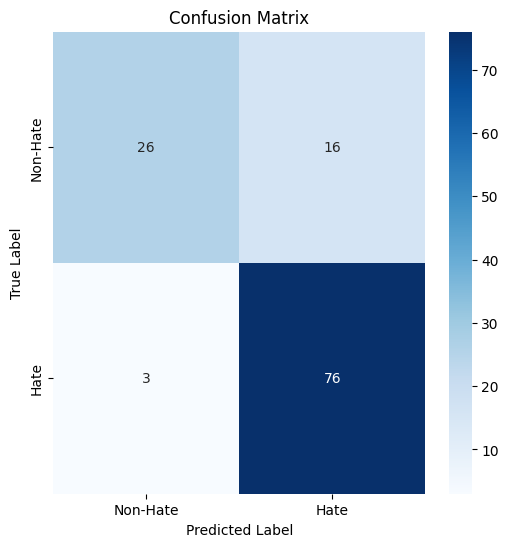

In [203]:
# Evaluation
def evaluate_model(model, test_features, test_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(test_features)
        _, predicted = torch.max(outputs, 1)
        
        # Calculate confusion matrix
        cm = confusion_matrix(test_labels.cpu(), predicted.cpu())
        print(classification_report(test_labels.cpu(), predicted.cpu(), target_names=['Non-Hate', 'Hate']))

        # Plot confusion matrix
        plt.figure(figsize=(6,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()
# Testing
evaluate_model(model_1, test_features_xlsr, test_labels_tensor_xlsr_bin)

**With 1D CNN Classifier**

In [204]:
# Define the 1D CNN model
class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1024, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = x.mean(dim=2)  # Global average pooling across the sequence
        x = self.dropout(self.fc1(x))
        x = self.fc2(x)
        return x
        
# Hyperparameters
num_classes = 2
learning_rate = 0.001
num_epochs = 20
batch_size = 16

In [58]:
'''train_features_xlsr.size()'''

'train_features_xlsr.size()'

In [207]:
# Reshape features for CNN
train_features_xlsr_cnn = train_features_xlsr.permute(0, 2, 1).to(device)  # Shape to [batch, 1024, 1]
test_features_xlsr_cnn = test_features_xlsr.permute(0, 2, 1).to(device)

# DataLoader setup
train_dataset_xlsr_cnn_bin = TensorDataset(train_features_xlsr_cnn, train_labels_tensor_xlsr_bin)
train_loader = DataLoader(train_dataset_xlsr_cnn_bin, batch_size=batch_size, shuffle=True)

# Model, Loss, Optimizer
model_2 = AudioCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)

# Training loop with progress bar and batching
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
            for batch_features, batch_labels in train_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                pbar.set_postfix({"Batch Loss": loss.item()})
                pbar.update(1)
        
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

train_model(model_2, train_loader, optimizer, criterion, num_epochs)

Epoch 1/20: 100%|██████████| 52/52 [00:00<00:00, 245.37batch/s, Batch Loss=0.511]


Epoch [1/20], Average Loss: 0.5305


Epoch 2/20: 100%|██████████| 52/52 [00:00<00:00, 240.99batch/s, Batch Loss=0.476]


Epoch [2/20], Average Loss: 0.5003


Epoch 3/20: 100%|██████████| 52/52 [00:00<00:00, 236.87batch/s, Batch Loss=0.452]


Epoch [3/20], Average Loss: 0.4565


Epoch 4/20: 100%|██████████| 52/52 [00:00<00:00, 266.24batch/s, Batch Loss=0.223]


Epoch [4/20], Average Loss: 0.4347


Epoch 5/20: 100%|██████████| 52/52 [00:00<00:00, 267.32batch/s, Batch Loss=0.522]


Epoch [5/20], Average Loss: 0.4362


Epoch 6/20: 100%|██████████| 52/52 [00:00<00:00, 252.30batch/s, Batch Loss=0.272]


Epoch [6/20], Average Loss: 0.4424


Epoch 7/20: 100%|██████████| 52/52 [00:00<00:00, 262.02batch/s, Batch Loss=0.274]


Epoch [7/20], Average Loss: 0.4382


Epoch 8/20: 100%|██████████| 52/52 [00:00<00:00, 257.91batch/s, Batch Loss=0.433]


Epoch [8/20], Average Loss: 0.4190


Epoch 9/20: 100%|██████████| 52/52 [00:00<00:00, 262.65batch/s, Batch Loss=0.346]


Epoch [9/20], Average Loss: 0.4157


Epoch 10/20: 100%|██████████| 52/52 [00:00<00:00, 269.36batch/s, Batch Loss=0.435]


Epoch [10/20], Average Loss: 0.4089


Epoch 11/20: 100%|██████████| 52/52 [00:00<00:00, 273.53batch/s, Batch Loss=0.716]


Epoch [11/20], Average Loss: 0.4087


Epoch 12/20: 100%|██████████| 52/52 [00:00<00:00, 264.27batch/s, Batch Loss=0.459]


Epoch [12/20], Average Loss: 0.4112


Epoch 13/20: 100%|██████████| 52/52 [00:00<00:00, 263.02batch/s, Batch Loss=0.328]


Epoch [13/20], Average Loss: 0.4013


Epoch 14/20: 100%|██████████| 52/52 [00:00<00:00, 266.41batch/s, Batch Loss=0.48]  


Epoch [14/20], Average Loss: 0.3909


Epoch 15/20: 100%|██████████| 52/52 [00:00<00:00, 261.12batch/s, Batch Loss=0.358]


Epoch [15/20], Average Loss: 0.3751


Epoch 16/20: 100%|██████████| 52/52 [00:00<00:00, 267.18batch/s, Batch Loss=0.574]


Epoch [16/20], Average Loss: 0.3977


Epoch 17/20: 100%|██████████| 52/52 [00:00<00:00, 264.30batch/s, Batch Loss=0.336]


Epoch [17/20], Average Loss: 0.3821


Epoch 18/20: 100%|██████████| 52/52 [00:00<00:00, 268.15batch/s, Batch Loss=0.512]


Epoch [18/20], Average Loss: 0.3755


Epoch 19/20: 100%|██████████| 52/52 [00:00<00:00, 267.37batch/s, Batch Loss=0.447]


Epoch [19/20], Average Loss: 0.3735


Epoch 20/20: 100%|██████████| 52/52 [00:00<00:00, 265.02batch/s, Batch Loss=0.33] 


Epoch [20/20], Average Loss: 0.3434


In [ ]:
import seaborn as sns

# Evaluation
def evaluate_model(model, test_features, test_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(test_features)
        _, predicted = torch.max(outputs, 1)
        
        # Calculate confusion matrix
        cm = confusion_matrix(test_labels.cpu(), predicted.cpu())
        print(classification_report(test_labels.cpu(), predicted.cpu(), target_names=['Non-Hate', 'Hate']))

        # Plot confusion matrix
        plt.figure(figsize=(6,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

evaluate_model(model_2, test_features_xlsr_cnn, test_labels_tensor_xlsr_bin)

# **Using the Model for Multi-class classification**

In [41]:
# Update model configuration to set pooling mode and use binary labels
pooling_mode = "mean"  # Using mean pooling for downsampling hidden states
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels_M,
    label2id={label: i for i, label in enumerate(multi_class_label_list)},
    id2label={i: label for i, label in enumerate(multi_class_label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)

target_sampling_rate = feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

The target sampling rate: 16000


In [42]:
# Extract multi-class labels
train_labels_multi = np.array([example['Multi-class Label'] for example in train_dataset])
test_labels_multi = np.array([example['Multi-class Label'] for example in test_dataset])

In [43]:
train_features_xlsr, train_labels_tensor_xlsr_multi = prepare_data(train_features, train_labels_multi, 830, 1, 1024)
test_features_xlsr, test_labels_tensor_xlsr_multi = prepare_data(test_features, test_labels_multi, 121, 1, 1024)

print(f"Shape of training features: {train_features_xlsr.shape}")
print(f"Number of training labels: {len(train_labels_tensor_xlsr_multi)}")

print(f"Shape of testing features: {test_features_xlsr.shape}")
print(f"Number of testing labels: {len(test_labels_tensor_xlsr_multi)}")

Shape of training features: torch.Size([830, 1, 1024])
Number of training labels: 830
Shape of testing features: torch.Size([121, 1, 1024])
Number of testing labels: 121


**Using LSTM Classifier**

In [214]:
'''device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate class weights based on training label distribution
class_counts = np.bincount(train_labels_multi)
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
class_weights = class_weights.to(device)  # Send to GPU if available
class_weights'''

'device = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\n# Calculate class weights based on training label distribution\nclass_counts = np.bincount(train_labels_multi)\nclass_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)\nclass_weights = class_weights.to(device)  # Send to GPU if available\nclass_weights'

In [48]:
# Update the LSTM model for multi-class classification
class AudioLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AudioLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=0.3, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(2 * num_layers, x.size(0), hidden_size).to(device)
        c0 = torch.zeros(2 * num_layers, x.size(0), hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters for multi-class classification
input_size = 1024
hidden_size = 128
num_layers = 2
num_classes = len(np.unique(train_labels_multi))  # Set num_classes to the number of unique labels
learning_rate = 0.002
num_epochs = 50
batch_size = 16

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to GPU
train_features_xlsr, train_labels_tensor_xlsr_multi = train_features_xlsr.to(device), train_labels_tensor_xlsr_multi.to(device)
test_features_xlsr, test_labels_tensor_xlsr_multi = test_features_xlsr.to(device), test_labels_tensor_xlsr_multi.to(device)

# Create DataLoader for batching
train_dataset_xlsr_multi_lstm = TensorDataset(train_features_xlsr, train_labels_tensor_xlsr_multi)
train_loader = DataLoader(train_dataset_xlsr_multi_lstm, batch_size=batch_size, shuffle=True)

In [50]:
# Model, Loss, Optimizer with Class Weights
model_3 = AudioLSTM(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # Use class weights here
optimizer = optim.Adam(model_3.parameters(), lr=learning_rate)

# Training loop with progress bar and batching
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
            for batch_features, batch_labels in train_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                pbar.set_postfix({"Batch Loss": loss.item()})
                pbar.update(1)
        
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

train_model(model_3, train_loader, optimizer, criterion, num_epochs)

Epoch 1/50: 100%|██████████| 52/52 [00:00<00:00, 72.06batch/s, Batch Loss=1.42]


Epoch [1/50], Average Loss: 1.5841


Epoch 2/50: 100%|██████████| 52/52 [00:00<00:00, 169.20batch/s, Batch Loss=1.29]


Epoch [2/50], Average Loss: 1.3809


Epoch 3/50: 100%|██████████| 52/52 [00:00<00:00, 162.16batch/s, Batch Loss=1.23]


Epoch [3/50], Average Loss: 1.3337


Epoch 4/50: 100%|██████████| 52/52 [00:00<00:00, 173.59batch/s, Batch Loss=1.46]


Epoch [4/50], Average Loss: 1.3147


Epoch 5/50: 100%|██████████| 52/52 [00:00<00:00, 175.55batch/s, Batch Loss=1.03] 


Epoch [5/50], Average Loss: 1.3086


Epoch 6/50: 100%|██████████| 52/52 [00:00<00:00, 175.21batch/s, Batch Loss=1.74] 


Epoch [6/50], Average Loss: 1.2778


Epoch 7/50: 100%|██████████| 52/52 [00:00<00:00, 174.24batch/s, Batch Loss=0.929]


Epoch [7/50], Average Loss: 1.2578


Epoch 8/50: 100%|██████████| 52/52 [00:00<00:00, 171.67batch/s, Batch Loss=1.53] 


Epoch [8/50], Average Loss: 1.2444


Epoch 9/50: 100%|██████████| 52/52 [00:00<00:00, 175.86batch/s, Batch Loss=1.38] 


Epoch [9/50], Average Loss: 1.2613


Epoch 10/50: 100%|██████████| 52/52 [00:00<00:00, 176.29batch/s, Batch Loss=1.28] 


Epoch [10/50], Average Loss: 1.2249


Epoch 11/50: 100%|██████████| 52/52 [00:00<00:00, 173.53batch/s, Batch Loss=1.31]


Epoch [11/50], Average Loss: 1.2616


Epoch 12/50: 100%|██████████| 52/52 [00:00<00:00, 176.94batch/s, Batch Loss=1.38] 


Epoch [12/50], Average Loss: 1.1946


Epoch 13/50: 100%|██████████| 52/52 [00:00<00:00, 172.82batch/s, Batch Loss=1.14] 


Epoch [13/50], Average Loss: 1.2401


Epoch 14/50: 100%|██████████| 52/52 [00:00<00:00, 176.30batch/s, Batch Loss=1.25] 


Epoch [14/50], Average Loss: 1.1951


Epoch 15/50: 100%|██████████| 52/52 [00:00<00:00, 178.15batch/s, Batch Loss=0.847]


Epoch [15/50], Average Loss: 1.1816


Epoch 16/50: 100%|██████████| 52/52 [00:00<00:00, 177.63batch/s, Batch Loss=1.36] 


Epoch [16/50], Average Loss: 1.1975


Epoch 17/50: 100%|██████████| 52/52 [00:00<00:00, 175.82batch/s, Batch Loss=1.14] 


Epoch [17/50], Average Loss: 1.1421


Epoch 18/50: 100%|██████████| 52/52 [00:00<00:00, 174.85batch/s, Batch Loss=0.662]


Epoch [18/50], Average Loss: 1.1218


Epoch 19/50: 100%|██████████| 52/52 [00:00<00:00, 180.57batch/s, Batch Loss=1.17] 


Epoch [19/50], Average Loss: 1.1591


Epoch 20/50: 100%|██████████| 52/52 [00:00<00:00, 176.32batch/s, Batch Loss=0.946]


Epoch [20/50], Average Loss: 1.1295


Epoch 21/50: 100%|██████████| 52/52 [00:00<00:00, 175.76batch/s, Batch Loss=0.912]


Epoch [21/50], Average Loss: 1.0877


Epoch 22/50: 100%|██████████| 52/52 [00:00<00:00, 176.75batch/s, Batch Loss=1.09] 


Epoch [22/50], Average Loss: 1.0949


Epoch 23/50: 100%|██████████| 52/52 [00:00<00:00, 175.72batch/s, Batch Loss=0.936]


Epoch [23/50], Average Loss: 1.0598


Epoch 24/50: 100%|██████████| 52/52 [00:00<00:00, 174.93batch/s, Batch Loss=1.1]  


Epoch [24/50], Average Loss: 1.0858


Epoch 25/50: 100%|██████████| 52/52 [00:00<00:00, 177.87batch/s, Batch Loss=1.33] 


Epoch [25/50], Average Loss: 1.0497


Epoch 26/50: 100%|██████████| 52/52 [00:00<00:00, 164.58batch/s, Batch Loss=0.681]


Epoch [26/50], Average Loss: 1.0730


Epoch 27/50: 100%|██████████| 52/52 [00:00<00:00, 173.79batch/s, Batch Loss=1.45] 


Epoch [27/50], Average Loss: 1.0521


Epoch 28/50: 100%|██████████| 52/52 [00:00<00:00, 177.55batch/s, Batch Loss=0.993]


Epoch [28/50], Average Loss: 0.9787


Epoch 29/50: 100%|██████████| 52/52 [00:00<00:00, 175.90batch/s, Batch Loss=1.08] 


Epoch [29/50], Average Loss: 0.9769


Epoch 30/50: 100%|██████████| 52/52 [00:00<00:00, 176.30batch/s, Batch Loss=1.31] 


Epoch [30/50], Average Loss: 1.0257


Epoch 31/50: 100%|██████████| 52/52 [00:00<00:00, 175.29batch/s, Batch Loss=0.931]


Epoch [31/50], Average Loss: 0.9565


Epoch 32/50: 100%|██████████| 52/52 [00:00<00:00, 175.55batch/s, Batch Loss=1.4]  


Epoch [32/50], Average Loss: 1.0632


Epoch 33/50: 100%|██████████| 52/52 [00:00<00:00, 176.41batch/s, Batch Loss=0.866]


Epoch [33/50], Average Loss: 0.9676


Epoch 34/50: 100%|██████████| 52/52 [00:00<00:00, 174.44batch/s, Batch Loss=1.1]  


Epoch [34/50], Average Loss: 0.9739


Epoch 35/50: 100%|██████████| 52/52 [00:00<00:00, 173.79batch/s, Batch Loss=1.02] 


Epoch [35/50], Average Loss: 0.9711


Epoch 36/50: 100%|██████████| 52/52 [00:00<00:00, 165.50batch/s, Batch Loss=0.754]


Epoch [36/50], Average Loss: 0.8680


Epoch 37/50: 100%|██████████| 52/52 [00:00<00:00, 159.25batch/s, Batch Loss=0.911]


Epoch [37/50], Average Loss: 0.8763


Epoch 38/50: 100%|██████████| 52/52 [00:00<00:00, 174.43batch/s, Batch Loss=0.79] 


Epoch [38/50], Average Loss: 0.8952


Epoch 39/50: 100%|██████████| 52/52 [00:00<00:00, 174.14batch/s, Batch Loss=1.05] 


Epoch [39/50], Average Loss: 0.8900


Epoch 40/50: 100%|██████████| 52/52 [00:00<00:00, 176.59batch/s, Batch Loss=1.24] 


Epoch [40/50], Average Loss: 0.9050


Epoch 41/50: 100%|██████████| 52/52 [00:00<00:00, 175.56batch/s, Batch Loss=1.05] 


Epoch [41/50], Average Loss: 0.9168


Epoch 42/50: 100%|██████████| 52/52 [00:00<00:00, 176.46batch/s, Batch Loss=0.838]


Epoch [42/50], Average Loss: 0.9105


Epoch 43/50: 100%|██████████| 52/52 [00:00<00:00, 176.94batch/s, Batch Loss=1.13] 


Epoch [43/50], Average Loss: 0.8491


Epoch 44/50: 100%|██████████| 52/52 [00:00<00:00, 176.85batch/s, Batch Loss=1.02] 


Epoch [44/50], Average Loss: 0.8141


Epoch 45/50: 100%|██████████| 52/52 [00:00<00:00, 177.30batch/s, Batch Loss=0.867]


Epoch [45/50], Average Loss: 0.8027


Epoch 46/50: 100%|██████████| 52/52 [00:00<00:00, 177.57batch/s, Batch Loss=0.442]


Epoch [46/50], Average Loss: 0.8218


Epoch 47/50: 100%|██████████| 52/52 [00:00<00:00, 175.08batch/s, Batch Loss=0.8]  


Epoch [47/50], Average Loss: 0.8888


Epoch 48/50: 100%|██████████| 52/52 [00:00<00:00, 177.19batch/s, Batch Loss=0.784]


Epoch [48/50], Average Loss: 0.8656


Epoch 49/50: 100%|██████████| 52/52 [00:00<00:00, 178.41batch/s, Batch Loss=0.508]


Epoch [49/50], Average Loss: 0.8060


Epoch 50/50: 100%|██████████| 52/52 [00:00<00:00, 176.58batch/s, Batch Loss=0.565]

Epoch [50/50], Average Loss: 0.7695


In [51]:
category_mapping

{'C': 0, 'G': 1, 'P': 2, 'R': 3, 'NH': 4}

              precision    recall  f1-score   support

           C       0.78      0.89      0.83        28
           G       0.59      0.64      0.62        25
           P       0.60      0.75      0.67        12
           R       0.29      0.14      0.19        14
    Non Hate       0.75      0.71      0.73        42

    accuracy                           0.68       121
   macro avg       0.60      0.63      0.61       121
weighted avg       0.66      0.68      0.66       121



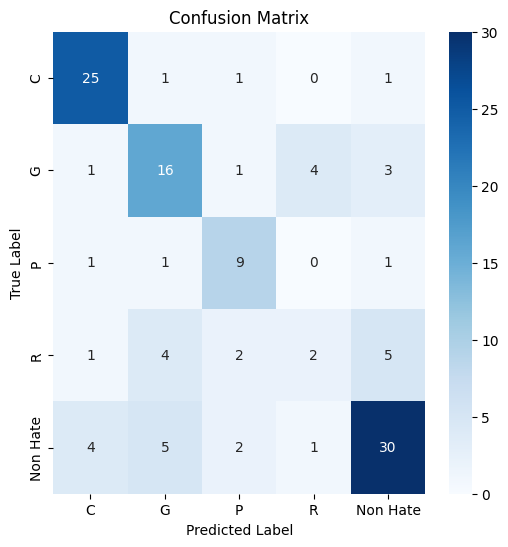

In [52]:
# Evaluation
def evaluate_model(model, test_features, test_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(test_features)
        _, predicted = torch.max(outputs, 1)
        
        # Calculate confusion matrix
        cm = confusion_matrix(test_labels.cpu(), predicted.cpu())
        print(classification_report(test_labels.cpu(), predicted.cpu(), target_names=['C','G','P','R','Non Hate'], zero_division=1))

        # Plot confusion matrix
        plt.figure(figsize=(6,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['C','G','P','R','Non Hate'], yticklabels=['C','G','P','R','Non Hate'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

# Testing
evaluate_model(model_3, test_features_xlsr, test_labels_tensor_xlsr_multi)

**Using 1D-CNN Classifier**

In [74]:
# Define the 1D CNN model for multi-class classification
class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1024, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)  # Output layer for multi-class
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = x.mean(dim=2)  # Global average pooling across the sequence
        x = self.dropout(self.fc1(x))
        x = self.fc2(x)
        return x

# Hyperparameters
num_classes = len(set(train_dataset['Multi-class Label']))  # The number of classes from your dataset
learning_rate = 0.001
num_epochs = 50
batch_size = 16

In [75]:
# Reshape features for CNN
train_features_xlsr_multi_cnn = train_features.permute(0, 2, 1).to(device)  # Shape to [batch, 1024, 1]
test_features_xlsr_multi_cnn = test_features.permute(0, 2, 1).to(device)

train_dataset_cnn_multi = TensorDataset(train_features_xlsr_multi_cnn, train_labels_tensor_xlsr_multi)
train_loader = DataLoader(train_dataset_cnn_multi, batch_size=batch_size, shuffle=True)

# Model, Loss, Optimizer
model_cnn_multi = AudioCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn_multi.parameters(), lr=learning_rate)

# Training loop with progress bar and batching
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
            for batch_features, batch_labels in train_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                pbar.set_postfix({"Batch Loss": loss.item()})
                pbar.update(1)
        
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

# Run training and evaluation
train_model(model_cnn_multi, train_loader, optimizer, criterion, num_epochs)

Epoch 1/50: 100%|██████████| 52/52 [00:00<00:00, 226.29batch/s, Batch Loss=1.61]


Epoch [1/50], Average Loss: 1.6142


Epoch 2/50: 100%|██████████| 52/52 [00:00<00:00, 256.34batch/s, Batch Loss=1.56]


Epoch [2/50], Average Loss: 1.5745


Epoch 3/50: 100%|██████████| 52/52 [00:00<00:00, 254.83batch/s, Batch Loss=1.25]


Epoch [3/50], Average Loss: 1.4290


Epoch 4/50: 100%|██████████| 52/52 [00:00<00:00, 248.61batch/s, Batch Loss=1.11]


Epoch [4/50], Average Loss: 1.3728


Epoch 5/50: 100%|██████████| 52/52 [00:00<00:00, 253.11batch/s, Batch Loss=1.56]


Epoch [5/50], Average Loss: 1.3576


Epoch 6/50: 100%|██████████| 52/52 [00:00<00:00, 265.43batch/s, Batch Loss=0.858]


Epoch [6/50], Average Loss: 1.3160


Epoch 7/50: 100%|██████████| 52/52 [00:00<00:00, 257.11batch/s, Batch Loss=1.27] 


Epoch [7/50], Average Loss: 1.3078


Epoch 8/50: 100%|██████████| 52/52 [00:00<00:00, 262.66batch/s, Batch Loss=1.3]  


Epoch [8/50], Average Loss: 1.2981


Epoch 9/50: 100%|██████████| 52/52 [00:00<00:00, 262.14batch/s, Batch Loss=1.54]


Epoch [9/50], Average Loss: 1.2842


Epoch 10/50: 100%|██████████| 52/52 [00:00<00:00, 249.27batch/s, Batch Loss=1.15] 


Epoch [10/50], Average Loss: 1.2805


Epoch 11/50: 100%|██████████| 52/52 [00:00<00:00, 255.93batch/s, Batch Loss=1.17] 


Epoch [11/50], Average Loss: 1.2440


Epoch 12/50: 100%|██████████| 52/52 [00:00<00:00, 253.92batch/s, Batch Loss=1.11] 


Epoch [12/50], Average Loss: 1.2419


Epoch 13/50: 100%|██████████| 52/52 [00:00<00:00, 250.64batch/s, Batch Loss=1.17] 


Epoch [13/50], Average Loss: 1.2473


Epoch 14/50: 100%|██████████| 52/52 [00:00<00:00, 251.76batch/s, Batch Loss=1.07] 


Epoch [14/50], Average Loss: 1.2422


Epoch 15/50: 100%|██████████| 52/52 [00:00<00:00, 254.42batch/s, Batch Loss=1.21] 


Epoch [15/50], Average Loss: 1.2172


Epoch 16/50: 100%|██████████| 52/52 [00:00<00:00, 257.00batch/s, Batch Loss=1.44] 


Epoch [16/50], Average Loss: 1.1949


Epoch 17/50: 100%|██████████| 52/52 [00:00<00:00, 259.54batch/s, Batch Loss=1.22] 


Epoch [17/50], Average Loss: 1.2638


Epoch 18/50: 100%|██████████| 52/52 [00:00<00:00, 245.53batch/s, Batch Loss=0.849]


Epoch [18/50], Average Loss: 1.1823


Epoch 19/50: 100%|██████████| 52/52 [00:00<00:00, 251.29batch/s, Batch Loss=1.77] 


Epoch [19/50], Average Loss: 1.1845


Epoch 20/50: 100%|██████████| 52/52 [00:00<00:00, 257.23batch/s, Batch Loss=1.26] 


Epoch [20/50], Average Loss: 1.1757


Epoch 21/50: 100%|██████████| 52/52 [00:00<00:00, 260.56batch/s, Batch Loss=1]    


Epoch [21/50], Average Loss: 1.2101


Epoch 22/50: 100%|██████████| 52/52 [00:00<00:00, 264.99batch/s, Batch Loss=1.12] 


Epoch [22/50], Average Loss: 1.1555


Epoch 23/50: 100%|██████████| 52/52 [00:00<00:00, 259.10batch/s, Batch Loss=1.22] 


Epoch [23/50], Average Loss: 1.1561


Epoch 24/50: 100%|██████████| 52/52 [00:00<00:00, 258.81batch/s, Batch Loss=0.931]


Epoch [24/50], Average Loss: 1.1723


Epoch 25/50: 100%|██████████| 52/52 [00:00<00:00, 262.42batch/s, Batch Loss=1.01] 

Epoch [25/50], Average Loss: 1.1369



Epoch 26/50: 100%|██████████| 52/52 [00:00<00:00, 246.70batch/s, Batch Loss=1.11] 


Epoch [26/50], Average Loss: 1.1435


Epoch 27/50: 100%|██████████| 52/52 [00:00<00:00, 264.61batch/s, Batch Loss=1.29] 


Epoch [27/50], Average Loss: 1.1216


Epoch 28/50: 100%|██████████| 52/52 [00:00<00:00, 254.59batch/s, Batch Loss=0.925]


Epoch [28/50], Average Loss: 1.1122


Epoch 29/50: 100%|██████████| 52/52 [00:00<00:00, 255.01batch/s, Batch Loss=1.04] 


Epoch [29/50], Average Loss: 1.1247


Epoch 30/50: 100%|██████████| 52/52 [00:00<00:00, 259.32batch/s, Batch Loss=1.14] 


Epoch [30/50], Average Loss: 1.1372


Epoch 31/50: 100%|██████████| 52/52 [00:00<00:00, 263.20batch/s, Batch Loss=1.23] 


Epoch [31/50], Average Loss: 1.1124


Epoch 32/50: 100%|██████████| 52/52 [00:00<00:00, 258.89batch/s, Batch Loss=1.48] 


Epoch [32/50], Average Loss: 1.1176


Epoch 33/50: 100%|██████████| 52/52 [00:00<00:00, 260.05batch/s, Batch Loss=0.852]


Epoch [33/50], Average Loss: 1.1081


Epoch 34/50: 100%|██████████| 52/52 [00:00<00:00, 253.57batch/s, Batch Loss=0.957]


Epoch [34/50], Average Loss: 1.0950


Epoch 35/50: 100%|██████████| 52/52 [00:00<00:00, 260.72batch/s, Batch Loss=0.92] 


Epoch [35/50], Average Loss: 1.0989


Epoch 36/50: 100%|██████████| 52/52 [00:00<00:00, 263.20batch/s, Batch Loss=0.773]


Epoch [36/50], Average Loss: 1.0573


Epoch 37/50: 100%|██████████| 52/52 [00:00<00:00, 258.39batch/s, Batch Loss=1.2]  


Epoch [37/50], Average Loss: 1.0379


Epoch 38/50: 100%|██████████| 52/52 [00:00<00:00, 200.82batch/s, Batch Loss=1.04] 


Epoch [38/50], Average Loss: 1.0600


Epoch 39/50: 100%|██████████| 52/52 [00:00<00:00, 214.97batch/s, Batch Loss=0.719]


Epoch [39/50], Average Loss: 1.0944


Epoch 40/50: 100%|██████████| 52/52 [00:00<00:00, 235.62batch/s, Batch Loss=1.53] 


Epoch [40/50], Average Loss: 1.0413


Epoch 41/50: 100%|██████████| 52/52 [00:00<00:00, 233.65batch/s, Batch Loss=1.17] 


Epoch [41/50], Average Loss: 0.9820


Epoch 42/50: 100%|██████████| 52/52 [00:00<00:00, 240.12batch/s, Batch Loss=1.45] 


Epoch [42/50], Average Loss: 1.0216


Epoch 43/50: 100%|██████████| 52/52 [00:00<00:00, 228.05batch/s, Batch Loss=1.14] 


Epoch [43/50], Average Loss: 0.9902


Epoch 44/50: 100%|██████████| 52/52 [00:00<00:00, 243.61batch/s, Batch Loss=0.608]


Epoch [44/50], Average Loss: 0.9822


Epoch 45/50: 100%|██████████| 52/52 [00:00<00:00, 259.74batch/s, Batch Loss=0.69] 


Epoch [45/50], Average Loss: 0.9343


Epoch 46/50: 100%|██████████| 52/52 [00:00<00:00, 261.46batch/s, Batch Loss=1.01] 


Epoch [46/50], Average Loss: 0.9463


Epoch 47/50: 100%|██████████| 52/52 [00:00<00:00, 260.33batch/s, Batch Loss=0.752]


Epoch [47/50], Average Loss: 0.9511


Epoch 48/50: 100%|██████████| 52/52 [00:00<00:00, 247.70batch/s, Batch Loss=0.796]


Epoch [48/50], Average Loss: 0.9490


Epoch 49/50: 100%|██████████| 52/52 [00:00<00:00, 224.66batch/s, Batch Loss=0.688]


Epoch [49/50], Average Loss: 0.8958


Epoch 50/50: 100%|██████████| 52/52 [00:00<00:00, 260.71batch/s, Batch Loss=1.15] 

Epoch [50/50], Average Loss: 0.8920


              precision    recall  f1-score   support

     Class 0       0.79      0.79      0.79        28
     Class 1       0.54      0.88      0.67        25
     Class 2       0.58      0.58      0.58        12
     Class 3       0.25      0.14      0.18        14
     Class 4       0.84      0.64      0.73        42

    accuracy                           0.66       121
   macro avg       0.60      0.61      0.59       121
weighted avg       0.67      0.66      0.65       121



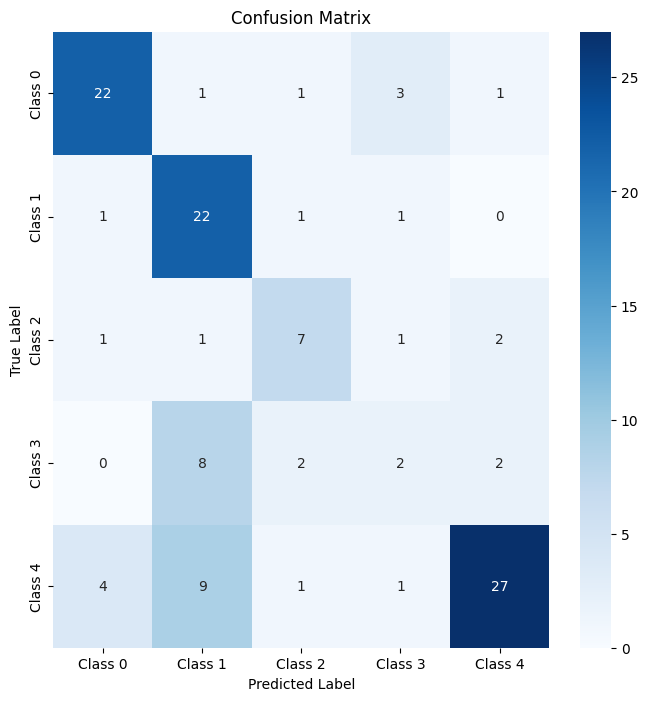

In [76]:
# Evaluation
def evaluate_model(model, test_features, test_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(test_features)
        _, predicted = torch.max(outputs, 1)
        
        # Calculate confusion matrix
        cm = confusion_matrix(test_labels.cpu(), predicted.cpu())
        print(classification_report(test_labels.cpu(), predicted.cpu(), target_names=[f'Class {i}' for i in range(num_classes)]))

        # Plot confusion matrix
        plt.figure(figsize=(8,8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[f'Class {i}' for i in range(num_classes)], yticklabels=[f'Class {i}' for i in range(num_classes)])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

evaluate_model(model_cnn_multi, test_features_xlsr_multi_cnn, test_labels_tensor_xlsr_multi)

# **MODEL - 2 (Indic - Wav2Vec2)**

# **Using the model for Binary Classification**

In [ ]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification

# Load the feature extractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/wav2vec2-base-superb-er")

# Initialize the processor for Wav2Vec2
#processor = Wav2Vec2Processor.from_pretrained("superb/wav2vec2-base-superb-er")

# Load the model with ignore_mismatched_sizes=True to handle custom label size
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "superb/wav2vec2-base-superb-er",
    num_labels=2,  # Set for binary classification
    ignore_mismatched_sizes=True  # Adjust layer sizes for mismatches
)

In [79]:
import torchaudio
import torch

def load_audio_data(dataset, target_length=16000*10):  # e.g., 10 seconds for a fixed length
    audio_inputs = []
    labels = []
    
    for row in dataset:
        audio_path = row['New File Path']
        label = row['Binary Label']
        
        # Load the audio file
        waveform, sample_rate = torchaudio.load(audio_path)

        # Resample if needed
        if sample_rate != 16000:
            waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
        
        # If the waveform is longer than target_length, truncate it
        if waveform.shape[1] > target_length:
            waveform = waveform[:, :target_length]
        # If the waveform is shorter, pad it with zeros
        elif waveform.shape[1] < target_length:
            padding = target_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        
        audio_inputs.append(waveform.squeeze(0))  # Remove the channel dimension
        labels.append(label)

    return torch.stack(audio_inputs), torch.tensor(labels)

# Load train and test data with a fixed target length
train_inputs, train_labels = load_audio_data(train_dataset)
test_inputs, test_labels = load_audio_data(test_dataset)

print(f"Train inputs shape: {train_inputs.shape}")  # Now they should all be the same length

Train inputs shape: torch.Size([830, 160000])


In [80]:
from torch.utils.data import DataLoader

# Create DataLoaders
train_loader_indic_wav2 = DataLoader(list(zip(train_inputs, train_labels)), batch_size=16, shuffle=True)
test_loader_indic_wav2 = DataLoader(list(zip(test_inputs, test_labels)), batch_size=16, shuffle=False)

In [81]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("Using CPU")


Using GPU: Tesla T4


In [46]:
from tqdm import tqdm

# Set optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Move model to GPU
model.to(device)

# Training loop
model.train()
num_epochs = 15
for epoch in range(num_epochs):  # Number of epochs
    # Create a progress bar for the training data
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for batch in train_loader:
            # Unpack the batch and move data to GPU
            inputs, labels = batch[0].to(device), batch[1].to(device)  # Move inputs and labels to GPU

            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs).logits  # Forward pass
            loss = torch.nn.functional.cross_entropy(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            
            pbar.set_postfix(loss=loss.item())  # Update progress bar with current loss
            pbar.update(1)  # Increment the progress bar
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')  # Print the loss for the epoch

Epoch 1/15:   0%|          | 0/30 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Epoch 1/15: 100%|██████████| 30/30 [01:28<00:00,  2.96s/batch, loss=0.67] 


Epoch 1/15, Loss: 0.6695173978805542


Epoch 2/15: 100%|██████████| 30/30 [01:33<00:00,  3.11s/batch, loss=0.589]


Epoch 2/15, Loss: 0.5891445875167847


Epoch 3/15: 100%|██████████| 30/30 [01:32<00:00,  3.09s/batch, loss=0.642]


Epoch 3/15, Loss: 0.6421318054199219


Epoch 4/15: 100%|██████████| 30/30 [01:32<00:00,  3.08s/batch, loss=0.263]


Epoch 4/15, Loss: 0.26298055052757263


Epoch 5/15: 100%|██████████| 30/30 [01:33<00:00,  3.11s/batch, loss=0.443]


Epoch 5/15, Loss: 0.44303613901138306


Epoch 6/15: 100%|██████████| 30/30 [01:32<00:00,  3.10s/batch, loss=0.319] 


Epoch 6/15, Loss: 0.31900835037231445


Epoch 7/15: 100%|██████████| 30/30 [01:32<00:00,  3.07s/batch, loss=0.393] 


Epoch 7/15, Loss: 0.3926810622215271


Epoch 8/15: 100%|██████████| 30/30 [01:32<00:00,  3.08s/batch, loss=0.339] 


Epoch 8/15, Loss: 0.3393155038356781


Epoch 9/15: 100%|██████████| 30/30 [01:32<00:00,  3.08s/batch, loss=0.283] 


Epoch 9/15, Loss: 0.28326788544654846


Epoch 10/15: 100%|██████████| 30/30 [01:33<00:00,  3.10s/batch, loss=0.0679]


Epoch 10/15, Loss: 0.06794524192810059


Epoch 11/15: 100%|██████████| 30/30 [01:32<00:00,  3.08s/batch, loss=0.114] 


Epoch 11/15, Loss: 0.1138620376586914


Epoch 12/15: 100%|██████████| 30/30 [01:32<00:00,  3.09s/batch, loss=0.0185]


Epoch 12/15, Loss: 0.018523843958973885


Epoch 13/15: 100%|██████████| 30/30 [01:32<00:00,  3.08s/batch, loss=0.0238] 


Epoch 13/15, Loss: 0.023793159052729607


Epoch 14/15: 100%|██████████| 30/30 [01:33<00:00,  3.12s/batch, loss=0.0369] 


Epoch 14/15, Loss: 0.036923013627529144


Epoch 15/15: 100%|██████████| 30/30 [01:32<00:00,  3.08s/batch, loss=0.0485] 

Epoch 15/15, Loss: 0.04850054532289505


In [47]:
from tqdm import tqdm

# Set the model to evaluation mode
model.eval()

# Store predictions and true labels
all_predictions = []
all_labels = []

# Testing loop
with torch.no_grad():  # Disable gradient calculation for evaluation
    with tqdm(total=len(test_loader), desc='Testing', unit='batch') as pbar:
        for batch in test_loader:
            # Unpack the batch and move data to GPU
            inputs, labels = batch[0].to(device), batch[1].to(device)  # Move inputs and labels to GPU
            
            # Forward pass
            outputs = model(inputs).logits  # Get logits from the model
            
            # Get predictions
            predictions = torch.argmax(outputs, dim=1)  # Get predicted class indices
            
            # Store predictions and labels
            all_predictions.extend(predictions.cpu().numpy())  # Move to CPU and convert to numpy
            all_labels.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy
            
            pbar.update(1)  # Increment the progress bar

# After the testing loop, you can evaluate your model's performance
# You can calculate accuracy or any other metrics you prefer
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Optionally, you can also print a classification report
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_predictions))

Testing: 100%|██████████| 8/8 [00:05<00:00,  1.51batch/s]

Accuracy: 90.08%
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        42
           1       0.92      0.92      0.92        79

    accuracy                           0.90       121
   macro avg       0.89      0.89      0.89       121
weighted avg       0.90      0.90      0.90       121



# **Using the model for Multi-class classification**

In [85]:
# Load the model with the number of labels set for multi-class classification
model_multi_indic = Wav2Vec2ForSequenceClassification.from_pretrained(
    "superb/wav2vec2-base-superb-er",
    num_labels=len(train_dataset.unique('Multi-class Label')),  # Set for multi-class classification
    ignore_mismatched_sizes=True  # Adjust layer sizes for mismatches
)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at superb/wav2vec2-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
def load_audio_data_multi(dataset, target_length=16000*10):  # e.g., 10 seconds for a fixed length
    audio_inputs_multi = []
    multi_class_labels = []
    
    for row in dataset:
        audio_path = row['New File Path']
        label = row['Multi-class Label']  # Change to multi-class label
        
        # Load the audio file
        waveform, sample_rate = torchaudio.load(audio_path)

        # Resample if needed
        if sample_rate != 16000:
            waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
        
        # If the waveform is longer than target_length, truncate it
        if waveform.shape[1] > target_length:
            waveform = waveform[:, :target_length]
        # If the waveform is shorter, pad it with zeros
        elif waveform.shape[1] < target_length:
            padding = target_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        
        audio_inputs_multi.append(waveform.squeeze(0))  # Remove the channel dimension
        multi_class_labels.append(label)

    return torch.stack(audio_inputs_multi), torch.tensor(multi_class_labels)

# Load train and test data for multi-class classification
train_inputs_multi, train_labels_multi = load_audio_data_multi(train_dataset)
test_inputs_multi, test_labels_multi = load_audio_data_multi(test_dataset)

print(f"Train inputs shape for multi-class: {train_inputs_multi.shape}")  # Now they should all be the same length

Train inputs shape for multi-class: torch.Size([830, 160000])


In [87]:
# Create DataLoaders for multi-class classification
train_loader_multi_indic = DataLoader(list(zip(train_inputs_multi, train_labels_multi)), batch_size=16, shuffle=True)
test_loader_multi_indic = DataLoader(list(zip(test_inputs_multi, test_labels_multi)), batch_size=16, shuffle=False)

In [89]:
# Set optimizer for multi-class classification
optimizer_multi = torch.optim.AdamW(model_multi_indic.parameters(), lr=1e-5)

# Move model to GPU
model_multi_indic.to(device)

# Training loop for multi-class classification
model_multi_indic.train()
num_epochs_multi = 15
for epoch in range(num_epochs_multi):  # Number of epochs
    # Create a progress bar for the training data
    with tqdm(total=len(train_loader_multi_indic), desc=f'Epoch {epoch + 1}/{num_epochs_multi}', unit='batch') as pbar:
        for batch in train_loader_multi_indic:
            # Unpack the batch and move data to GPU
            inputs, labels = batch[0].to(device), batch[1].to(device)  # Move inputs and labels to GPU

            optimizer_multi.zero_grad()  # Reset gradients
            outputs = model_multi_indic(inputs).logits  # Forward pass
            loss = torch.nn.functional.cross_entropy(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer_multi.step()  # Update weights
            
            pbar.set_postfix(loss=loss.item())  # Update progress bar with current loss
            pbar.update(1)  # Increment the progress bar
    print(f'Epoch {epoch + 1}/{num_epochs_multi}, Loss: {loss.item()}')  # Print the loss for the epoch

Epoch 1/15:   0%|          | 0/52 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Epoch 1/15: 100%|██████████| 52/52 [02:45<00:00,  3.19s/batch, loss=1.54]


Epoch 1/15, Loss: 1.5410152673721313


Epoch 2/15: 100%|██████████| 52/52 [02:46<00:00,  3.20s/batch, loss=1.63]


Epoch 2/15, Loss: 1.6283384561538696


Epoch 3/15: 100%|██████████| 52/52 [02:45<00:00,  3.18s/batch, loss=1.4] 


Epoch 3/15, Loss: 1.3978322744369507


Epoch 4/15: 100%|██████████| 52/52 [02:45<00:00,  3.19s/batch, loss=1.4] 


Epoch 4/15, Loss: 1.404030203819275


Epoch 5/15: 100%|██████████| 52/52 [02:45<00:00,  3.19s/batch, loss=1.33] 


Epoch 5/15, Loss: 1.3307584524154663


Epoch 6/15: 100%|██████████| 52/52 [02:45<00:00,  3.19s/batch, loss=0.863]


Epoch 6/15, Loss: 0.8625662922859192


Epoch 7/15: 100%|██████████| 52/52 [02:45<00:00,  3.19s/batch, loss=0.56] 


Epoch 7/15, Loss: 0.5604661703109741


Epoch 8/15: 100%|██████████| 52/52 [02:45<00:00,  3.18s/batch, loss=0.911]


Epoch 8/15, Loss: 0.9109775424003601


Epoch 9/15: 100%|██████████| 52/52 [02:44<00:00,  3.17s/batch, loss=0.486]


Epoch 9/15, Loss: 0.48598307371139526


Epoch 10/15: 100%|██████████| 52/52 [02:44<00:00,  3.16s/batch, loss=0.944]


Epoch 10/15, Loss: 0.9436715245246887


Epoch 11/15: 100%|██████████| 52/52 [02:45<00:00,  3.18s/batch, loss=0.58] 


Epoch 11/15, Loss: 0.5804420709609985


Epoch 12/15: 100%|██████████| 52/52 [02:45<00:00,  3.18s/batch, loss=0.292]


Epoch 12/15, Loss: 0.29159894585609436


Epoch 13/15: 100%|██████████| 52/52 [02:44<00:00,  3.16s/batch, loss=0.332]


Epoch 13/15, Loss: 0.3321075141429901


Epoch 14/15: 100%|██████████| 52/52 [02:45<00:00,  3.18s/batch, loss=0.811]


Epoch 14/15, Loss: 0.8114748001098633


Epoch 15/15: 100%|██████████| 52/52 [02:46<00:00,  3.21s/batch, loss=0.284]

Epoch 15/15, Loss: 0.28406384587287903


Testing: 100%|██████████| 8/8 [00:05<00:00,  1.42batch/s]


Multi-class Accuracy: 67.77%
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        28
           1       0.68      0.60      0.64        25
           2       0.82      0.75      0.78        12
           3       0.35      0.50      0.41        14
           4       0.80      0.76      0.78        42

    accuracy                           0.68       121
   macro avg       0.67      0.66      0.66       121
weighted avg       0.70      0.68      0.69       121



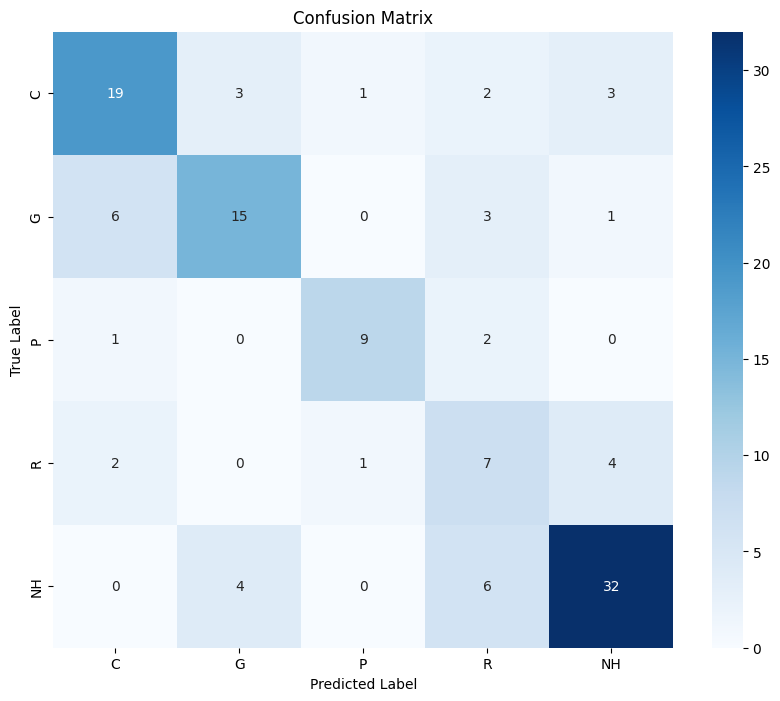

In [97]:
# Set the model to evaluation mode for multi-class classification
model_multi_indic.eval()

# Store predictions and true labels
all_predictions_multi = []
all_labels_multi = []

# Testing loop for multi-class classification
with torch.no_grad():  # Disable gradient calculation for evaluation
    with tqdm(total=len(test_loader_multi_indic), desc='Testing', unit='batch') as pbar:
        for batch in test_loader_multi_indic:
            # Unpack the batch and move data to GPU
            inputs, labels = batch[0].to(device), batch[1].to(device)  # Move inputs and labels to GPU
            
            # Forward pass
            outputs = model_multi_indic(inputs).logits  # Get logits from the model
            
            # Get predictions
            predictions = torch.argmax(outputs, dim=1)  # Get predicted class indices
            
            # Store predictions and labels
            all_predictions_multi.extend(predictions.cpu().numpy())  # Move to CPU and convert to numpy
            all_labels_multi.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy
            
            pbar.update(1)  # Increment the progress bar

# Calculate accuracy for multi-class classification
accuracy_multi = accuracy_score(all_labels_multi, all_predictions_multi)
print(f'Multi-class Accuracy: {accuracy_multi * 100:.2f}%')

# Print a classification report for multi-class classification
print("Classification Report:")
print(classification_report(all_labels_multi, all_predictions_multi))

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels_multi, all_predictions_multi)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels= ['C','G','P','R','NH'], yticklabels=['C','G','P','R','NH'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **MODEL - 3 (Audio Spectrogram Transformer)**

In [102]:
from transformers import AutoProcessor, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

In [106]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("audio-classification", model="MIT/ast-finetuned-audioset-10-10-0.4593")

# Load model directly
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification

extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model_ast = AutoModelForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


# **Using the model for Binary Classification**

In [114]:
def preprocess_function(example):
    # Load the audio file and resample if necessary
    audio_path = example["New File Path"]
    audio_data, sampling_rate = librosa.load(audio_path, sr=16000)  # AST expects 16kHz
    inputs = extractor(audio_data, sampling_rate=sampling_rate, return_tensors="pt", padding=True)
    inputs["labels"] = example["Binary Label"]  # or "Multi-class Label" for multi-class classification
    return inputs

# Map the preprocessing function to the dataset
train_dataset_ast = train_dataset.map(preprocess_function)
test_dataset_ast = test_dataset.map(preprocess_function)

# Data Collator and Trainer Setup
def data_collator(features):
    input_values = [torch.tensor(f["input_values"]).squeeze() for f in features]
    labels = [f["labels"] for f in features]
    
    # Stack inputs and labels into a batch
    batch = {
        "input_values": torch.stack(input_values),
        "labels": torch.tensor(labels),
    }
    return batch

In [115]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
)

# Initialize Trainer
trainer = Trainer(
    model=model_ast,
    args=training_args,
    train_dataset=train_dataset_ast,
    eval_dataset=test_dataset_ast,
    data_collator=data_collator,
    tokenizer=extractor,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_30/4069543062.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,No log,0.389668
2,No log,0.488973
3,No log,0.522751
4,No log,0.707968
5,No log,0.828170
6,No log,0.854953
7,No log,0.747108
8,No log,0.778318
9,No log,0.791910
10,0.078900,0.793613


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=520, training_loss=0.0759167680783251, metrics={'train_runtime': 2487.4562, 'train_samples_per_second': 3.337, 'train_steps_per_second': 0.209, 'total_flos': 5.652328398716928e+17, 'train_loss': 0.0759167680783251, 'epoch': 10.0})

In [116]:
trainer.evaluate()

{'eval_loss': 0.7936132550239563,
 'eval_runtime': 20.4722,
 'eval_samples_per_second': 5.91,
 'eval_steps_per_second': 0.391,
 'epoch': 10.0}

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.71      0.78        42
           1       0.86      0.94      0.90        79

    accuracy                           0.86       121
   macro avg       0.86      0.83      0.84       121
weighted avg       0.86      0.86      0.86       121

Confusion Matrix:


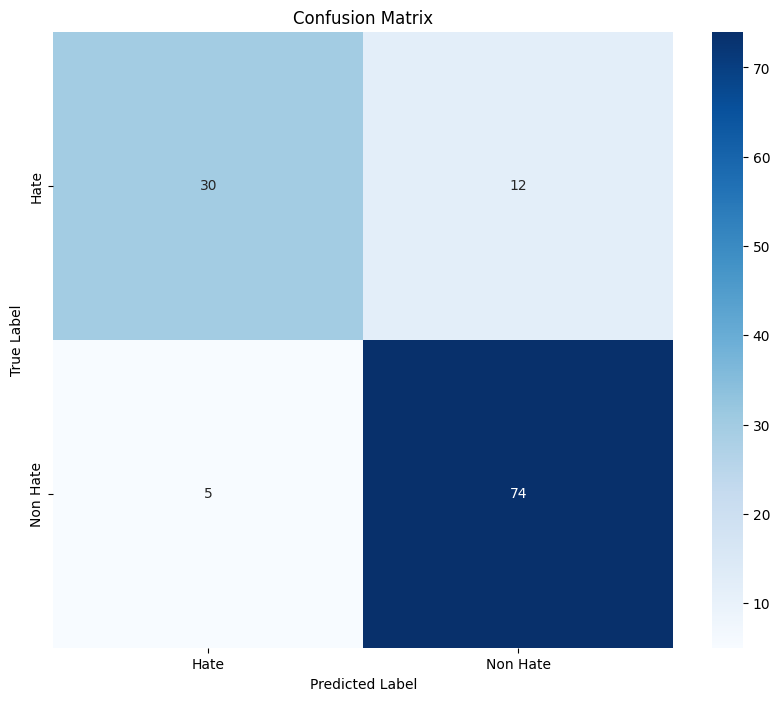

In [119]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: Make predictions on the test set
predictions = trainer.predict(test_dataset_ast)
pred_labels = np.argmax(predictions.predictions, axis=1)  # Get predicted labels
true_labels = predictions.label_ids  # True labels

# Step 2: Print Classification Report
print("Classification Report:")
print(classification_report(true_labels, pred_labels))

# Step 3: Print Confusion Matrix
print("Confusion Matrix:")
c_mat = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(c_mat, annot=True, fmt="d", cmap="Blues", xticklabels= ['Hate', 'Non Hate'], yticklabels= ['Hate', 'Non Hate'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **Using the model for Multi-class Classification**

In [122]:
def preprocess_function_multi(example):
    # Load the audio file and resample if necessary
    audio_path = example["New File Path"]
    audio_data, sampling_rate = librosa.load(audio_path, sr=16000)  # AST expects 16kHz
    inputs = extractor(audio_data, sampling_rate=sampling_rate, return_tensors="pt", padding=True)
    inputs["labels"] = example["Multi-class Label"]  # or "Multi-class Label" for multi-class classification
    return inputs

# Map the preprocessing function to the dataset
train_dataset_ast_multi = train_dataset.map(preprocess_function_multi)
test_dataset_ast_multi = test_dataset.map(preprocess_function_multi)

# Data Collator and Trainer Setup
def data_collator(features):
    input_values = [torch.tensor(f["input_values"]).squeeze() for f in features]
    labels = [f["labels"] for f in features]
    
    # Stack inputs and labels into a batch
    batch = {
        "input_values": torch.stack(input_values),
        "labels": torch.tensor(labels),
    }
    return batch

In [123]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
)

# Initialize Trainer
trainer_multi = Trainer(
    model=model_ast,
    args=training_args,
    train_dataset=train_dataset_ast_multi,
    eval_dataset=test_dataset_ast_multi,
    data_collator=data_collator,
    tokenizer=extractor,
)

trainer_multi.train()
trainer_multi.evaluate()

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_30/4239542751.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_multi = Trainer(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,No log,0.932830
2,No log,0.794485
3,No log,0.898254
4,No log,1.196785
5,No log,1.128523
6,No log,1.110407
7,No log,1.169291
8,No log,1.178314
9,No log,1.190603
10,0.274300,1.194237


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

{'eval_loss': 1.194237470626831,
 'eval_runtime': 20.6516,
 'eval_samples_per_second': 5.859,
 'eval_steps_per_second': 0.387,
 'epoch': 10.0}

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89        28
           1       0.76      0.76      0.76        25
           2       0.91      0.83      0.87        12
           3       0.70      0.50      0.58        14
           4       0.83      0.83      0.83        42

    accuracy                           0.81       121
   macro avg       0.80      0.78      0.79       121
weighted avg       0.81      0.81      0.80       121

Confusion Matrix:


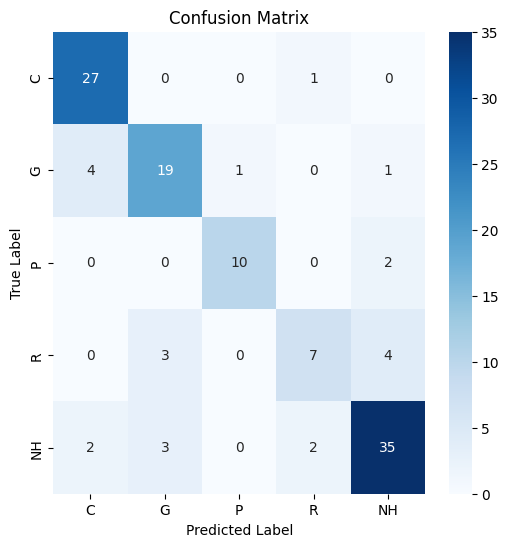

In [124]:
# Step 1: Make predictions on the test set
predictions_multi = trainer_multi.predict(test_dataset_ast_multi)
pred_labels_multi = np.argmax(predictions_multi.predictions, axis=1)  # Get predicted labels
true_labels_multi = predictions_multi.label_ids  # True labels

# Step 2: Print Classification Report
print("Classification Report:")
print(classification_report(true_labels_multi, pred_labels_multi))

# Step 3: Print Confusion Matrix
print("Confusion Matrix:")
c_mat = confusion_matrix(true_labels_multi, pred_labels_multi)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(c_mat, annot=True, fmt="d", cmap="Blues", xticklabels= ['C','G','P','R','NH'], yticklabels= ['C','G','P','R','NH'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()